# Experiment on Features(4), CatBoost Model
What about drop the best performing features?
- The result is, the feature importance plot shows the other features are working in this way!  
- However, the final result does not work that much. No leap in performance.  

In [1]:
import numpy as np
from catboost import Pool, CatBoostRegressor
import json
import pandas as pd
from tqdm import trange
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
to_drop = ['carrier_max_estimate', 'carrier_min_estimate']
cat_set = set({"shipment_method_id", "category_id", "bt", "package_size", "cross_city", "cross_state"})

In [14]:
list(train_set.columns)

['record_number',
 'shipment_method_id',
 'shipping_fee',
 'carrier_min_estimate',
 'carrier_max_estimate',
 'category_id',
 'item_price',
 'quantity',
 'declared_handling_days',
 'bt',
 'package_size',
 'weight',
 'tz_dis',
 'dis',
 'cross_city',
 'cross_state',
 'acc_hour',
 'pay_hour',
 'acc_date',
 'target']

In [3]:
i = 5

cb = CatBoostRegressor()
model = cb.load_model('../para/no_cmax_min/catboost_{}.cbm'.format(i))

train_set = pd.read_csv('../data/subtrain/train_{}.tsv'.format(i), sep='\t')
train_set['cross_city'] = train_set['cross_city'].astype('int')
train_set['cross_state'] = train_set['cross_state'].astype('int')
x_train = train_set.drop(['record_number', 'target'] + to_drop, axis=1)
y_train = train_set.target

print(x_train.columns)
cat_index = []
for idx, cn in enumerate(x_train.columns):
    if cn in cat_set:
        cat_index.append(idx)

Index(['shipment_method_id', 'shipping_fee', 'category_id', 'item_price',
       'quantity', 'declared_handling_days', 'bt', 'package_size', 'weight',
       'tz_dis', 'dis', 'cross_city', 'cross_state', 'acc_hour', 'pay_hour',
       'acc_date'],
      dtype='object')


In [4]:
train_pool = Pool(x_train, 
              y_train, 
              cat_features=cat_index,
              feature_names=list(x_train.columns))

In [5]:
len(x_train.columns)

16

In [6]:
feature_score = model.get_feature_importance(data=train_pool, type='ShapValues')
# ShapValues: A vector with contributions of each feature to the prediction for every input object and 
# the expected value of the model prediction for the object (average prediction given no knowledge about the object).
shap_val = np.sum(feature_score, axis=0)[:-1]

In [7]:
feature_importance = model.get_feature_importance(data=train_pool, type='FeatureImportance')
feature_importance

array([25.24225614,  3.36686587,  5.12111049,  2.82551534,  0.35215566,
        3.08239572,  1.2086868 ,  9.186488  ,  3.28941062,  4.58723452,
       15.04091931,  0.08779989,  1.17603471,  8.75960047,  0.05203393,
       16.62149254])

<AxesSubplot:>

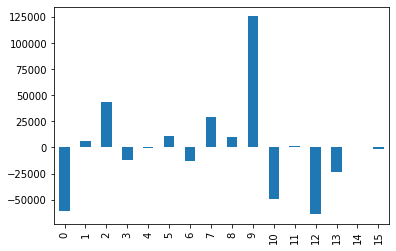

In [8]:
pd.Series(shap_val).plot.bar()

<AxesSubplot:>

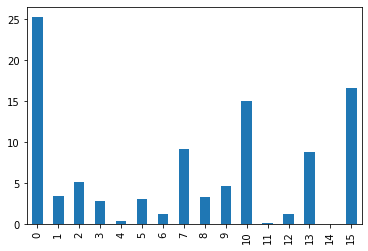

In [10]:
# equal to feature_importance for non-ranking metrics 
pred_val_change = model.get_feature_importance(data=train_pool, type='PredictionValuesChange')
pd.Series(pred_val_change).plot.bar()

<AxesSubplot:>

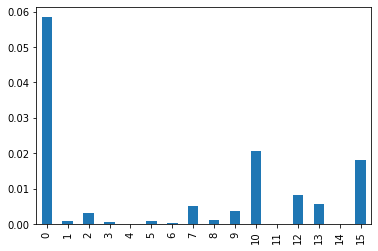

In [11]:
loss_change_score = model.get_feature_importance(data=train_pool, type='LossFunctionChange')
pd.Series(loss_change_score).plot.bar()

In [12]:
d = {'feature_name': x_train.columns, 'SHAP value': shap_val, 'feature_importance': feature_importance,'loss_change': loss_change_score}
feature_score = pd.DataFrame(data=d)
feature_score

,feature_name,SHAP value,feature_importance,loss_change
0,shipment_method_id,-60598.847466,25.242256,0.058498
1,shipping_fee,5742.413708,3.366866,0.000968
2,category_id,43091.904950,5.121110,0.003207
3,item_price,-11871.525636,2.825515,0.000689
4,quantity,-612.777541,0.352156,0.000119
5,declared_handling_days,10802.912008,3.082396,0.000769
6,bt,-13322.944694,1.208687,0.000297
7,package_size,28809.960175,9.186488,0.004992
8,weight,10476.514557,3.289411,0.001074
9,tz_dis,125352.827509,4.587235,0.003705
